In [27]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import pipeline

In [28]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [29]:
df = pd.DataFrame()
df["reviews"] = reviews
df

,reviews
0,Not Verified | LHR T5 BA Gold Wing worked wel...
1,Not Verified | Very good service on this rout...
2,✅ Trip Verified | Flight mainly let down by ...
3,✅ Trip Verified | Another awful experience b...
4,"✅ Trip Verified | The service was rude, full..."
...,...
995,✅ Trip Verified | London to Gothenburg. BA ar...
996,✅ Trip Verified | Orlando to Gatwick. Terribl...
997,✅ Trip Verified | Mahe to Stockholm via London...
998,✅ Trip Verified | Glasgow to Tampa via Gatwic...


In [30]:
df.to_csv("BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [31]:
df = pd.read_csv("BA_reviews.csv")
df.dropna(subset=['reviews'], inplace=True)

# Clean text
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return ' '.join([word for word in text.split() if word not in stop_words])

df["clean_review"] = df["reviews"].apply(clean_text)
df.to_csv("cleaned_airline_reviews.csv", index=False)

In [32]:
df["sentiment"] = df["clean_review"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["sentiment_label"] = df["sentiment"].apply(lambda x: "Positive" if x > 0 else "Negative" if x < 0 else "Neutral")
df

,Unnamed: 0,reviews,clean_review,sentiment,sentiment_label
0,0,Not Verified | LHR T5 BA Gold Wing worked wel...,verified lhr t5 ba gold wing worked well pleas...,0.447711,Positive
1,1,Not Verified | Very good service on this rout...,verified good service route ba2710 30th march ...,-0.159375,Negative
2,2,✅ Trip Verified | Flight mainly let down by ...,trip verified flight mainly let disagreeable f...,0.224747,Positive
3,3,✅ Trip Verified | Another awful experience b...,trip verified another awful experience british...,-0.320000,Negative
4,4,"✅ Trip Verified | The service was rude, full...",trip verified service rude full attitude food ...,-0.045833,Negative
...,...,...,...,...,...
995,995,✅ Trip Verified | London to Gothenburg. BA ar...,trip verified london gothenburg ba getting lot...,0.046429,Positive
996,996,✅ Trip Verified | Orlando to Gatwick. Terribl...,trip verified orlando gatwick terrible flight ...,-0.116667,Negative
997,997,✅ Trip Verified | Mahe to Stockholm via London...,trip verified mahe stockholm via london checke...,0.035714,Positive
998,998,✅ Trip Verified | Glasgow to Tampa via Gatwic...,trip verified glasgow tampa via gatwick early ...,0.282143,Positive


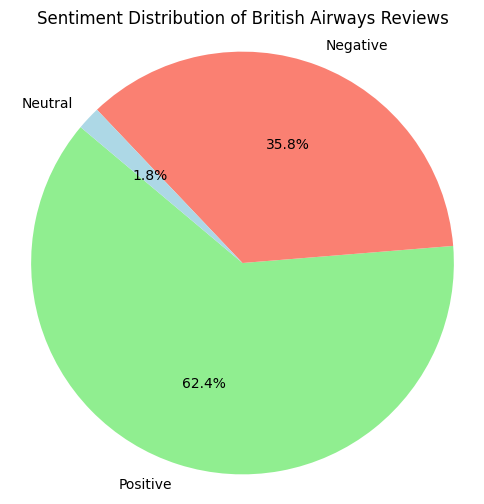

In [33]:
# Count the sentiment labels
sentiment_counts = df['sentiment_label'].value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
colors = ['lightgreen', 'salmon', 'lightblue']
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Sentiment Distribution of British Airways Reviews')
plt.axis('equal')  # Equal aspect ratio ensures the pie is a circle
plt.show()

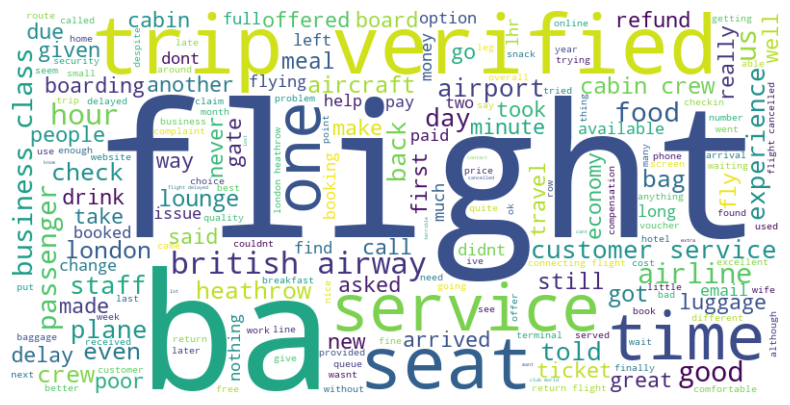

In [34]:
all_words = ' '.join(df["clean_review"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [35]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df["clean_review"])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display top words per topic
for i, topic in enumerate(lda.components_):
    print(f"Topic {i}: ", [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])

Topic 0:  ['business', 'staff', 'cabin', 'seats', 'crew', 'food', 'service', 'trip', 'flight', 'ba']
Topic 1:  ['pram', 'service', 'airways', 'british', 'cabin', 'plane', 'seats', 'luggage', 'staff', 'seat']
Topic 2:  ['hours', 'london', 'service', 'customer', 'told', 'airways', 'trip', 'british', 'ba', 'flight']
Topic 3:  ['time', 'crew', 'service', 'class', 'food', 'seat', 'trip', 'good', 'ba', 'flight']
Topic 4:  ['delayed', 'luggage', 'plane', 'service', 'time', 'crew', 'staff', 'trip', 'ba', 'flight']
